In [1]:
import sys
sys.path.insert(1, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\impedance.py') #\\impedance')
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from impedance.circuits import CustomCircuit
from impedance.plotting_BG import plot_nyquist
from impedance import preprocessing
from impedance import validation
from impedance.valid_BG import linKK

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [2]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*100%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par


In [3]:
M, mu, Z_linKK, res_real, res_imag = linKK(freqs, Z1, c=.8, max_M=100)

10 0.914820733920789 7.8513307819050695
20 0.6507651575530843 1.7130939562063134


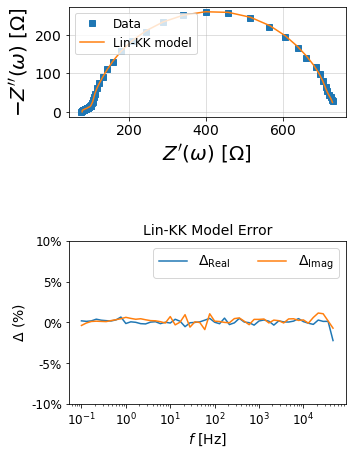

In [4]:
fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, Z1, fmt='s')

# plot measurement model
plot_nyquist(ax1, Z_linKK, fmt='-', scale=1e3, units='\Omega')

ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(freqs, res_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(freqs, res_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Lin-KK Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

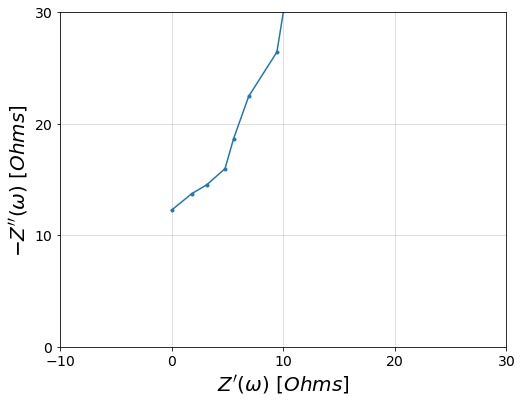

In [5]:
f_adj, Z_adj = freqs[16:], Z1[16:]

Z_adj = Z_adj - Z_adj.real[0]

fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, Z_adj)

ax.set_xlim(-10, 30)
ax.set_ylim(0,30)
plt.show()

### Subtracting a Gerischer admittance from this using tg=0.7 as fit from fr-XAS
### Varying the Rg to see what might be appropriate

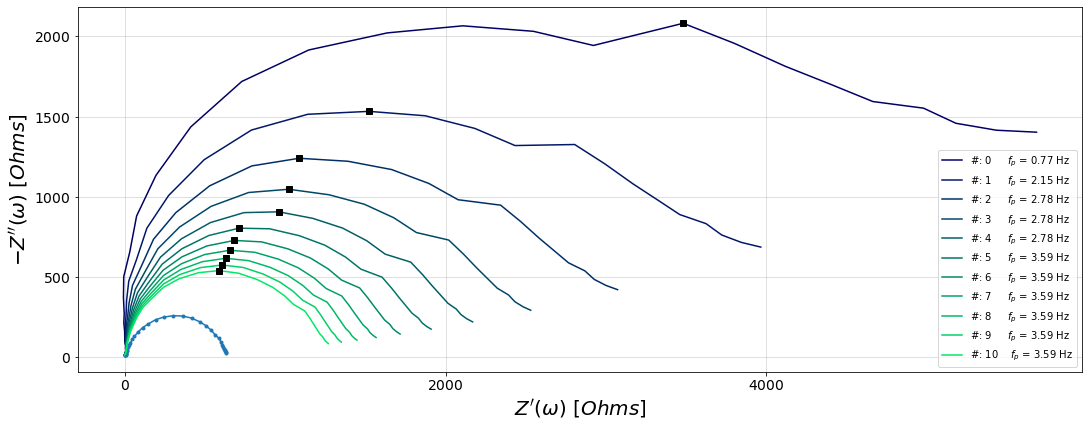

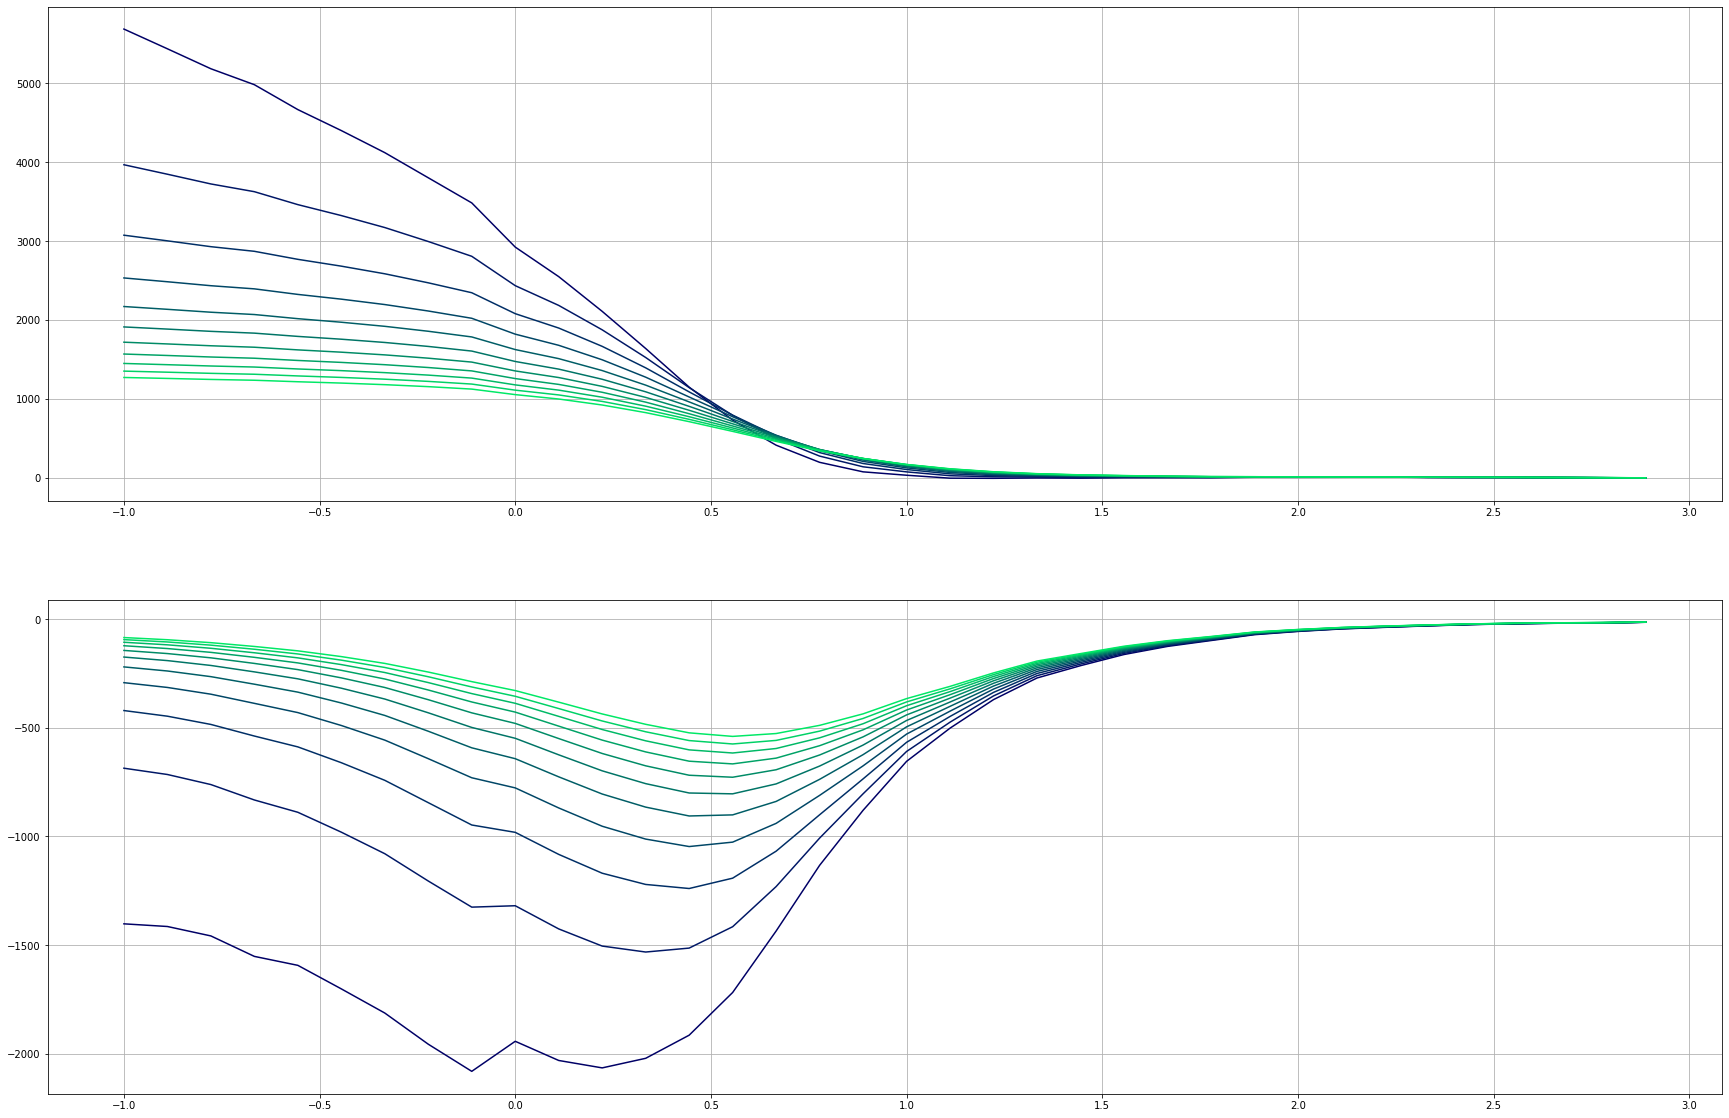

In [6]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .059, [2.85, 3.1], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 20))
plot_nyquist(ax, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
#     print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
#     if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
    f_p_idx = np.argmin(np.imag(Zs))
    f_p = f_adj[f_p_idx]

    ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
            c=(0, i/len(par_out), .4))
    ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
            c=(0, 0, 0))
    ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
            c=(0, i/len(par_out), .4))
    ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
            c=(0, i/len(par_out), .4))

    # ax.set_xlim(-80, 300)
    # ax.set_ylim(-80, 300)
    ax1.grid(True)
    ax2.grid(True)
    ax.legend()
        

In [7]:
def Res_fun(Rg, f, Z, tg):
    from impedance.circuit_elements import G
    Y = 1 / Z
    p = [Rg[0], tg]
    Zg = G(p, f)
    Yg = 1 / Zg
    Y_adj = Y - Yg
    Z_adj = 1 / Y_adj
    
    min_ind = np.argmin(Z_adj.imag)
    
#     n=1
#     res = Z_adj[min_ind+1].imag - Z_adj[min_ind-1].imag
    res = 0
    for n in range(1, 5):
        res = (Z_adj[min_ind+n].imag - Z_adj[min_ind-n].imag)**2
    print(min_ind, Rg, res, np.min(Z_adj.imag))
#     print(min_ind, Z_adj[min_ind], Z_adj[min_ind+1].imag - Z_adj[min_ind-1].imag
    return res

In [8]:
Res_fun([9300], f_adj, Z_adj, 0.7)

20 [9300] 1567.1641739228235 -315.4626729037721


1567.1641739228235

      fun: 1899.546126094117
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00025011])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 15
   status: 0
  success: True
        x: array([12885.95575056])


4.641589

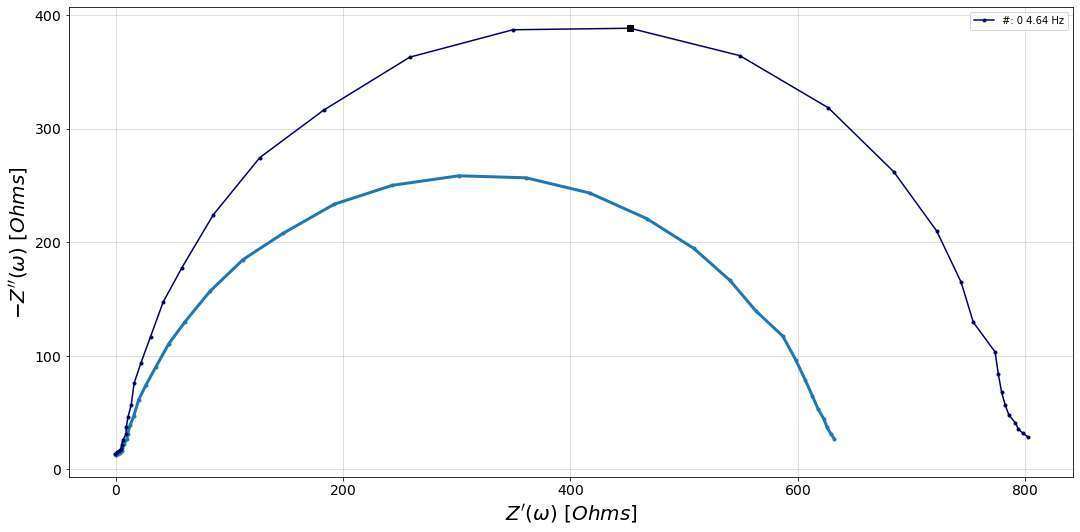

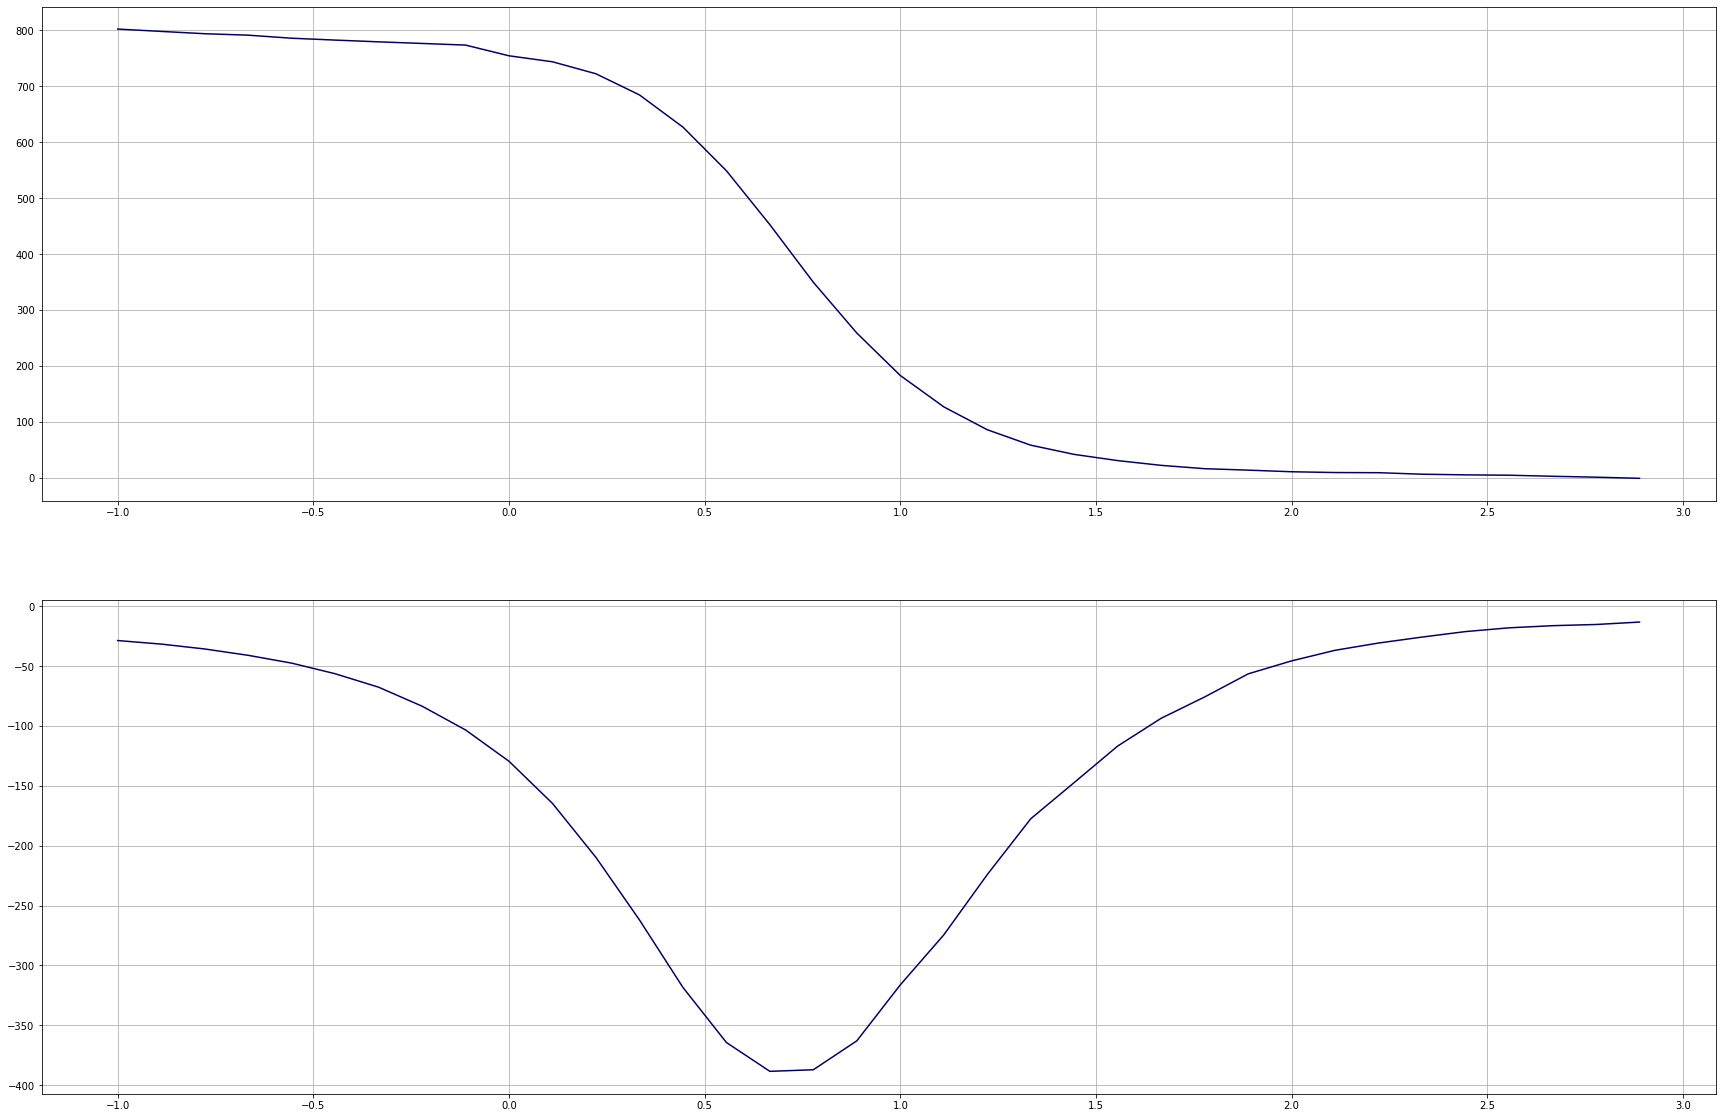

In [14]:
Zg0 = [3000] #, 0.7]
tg0 = 0.215
opts = {'maxiter': 10000}
Zg_fit = minimize(IC.Par_Zg_Res, Zg0, method='L-BFGS-B', args=(f_adj, Z_adj, tg0), bounds=((0, None),), options=opts)
# Zg_fit = minimize(Res_fun, Zg0, args=(f_adj, Z_adj, tg0), bounds = ((0, None),), options=opts)
print(Zg_fit)
# IC.sub_Zg_parallel(f_adj, Z_adj, Zg_fit.x[1], [Zg_fit.x[0]], num=1)
yy = IC.sub_Zg_parallel(f_adj, Z_adj, tg0, [3000], num=1)
# IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.5, 4], num=3)
IC.detect_peak_f(f_adj, yy[0])

In [504]:
result = least_squares(Res_fun, 10**3.9, args=(f_adj, Z_adj, .7), bounds=([1e3], [1e4]))
result

40 [7943.28234724] 255.3745017972064 -522.6680953626503
40 [7943.28246561] 255.3744556263232 -522.6680932576155
40 [8439.88705111] 108.76684420245377 -514.4850082375664
40 [8439.88717688] 108.76681734960118 -514.4850063174425
40 [8823.90345876] 45.4196777329799 -508.9371237801142
40 [8823.90359025] 45.41966175122332 -508.93712198263796
40 [9107.48251706] 18.434192712048947 -505.2084842001213
40 [9107.48265278] 18.43418309855827 -505.20848248383993
40 [9308.96769128] 7.189713774059553 -502.72770227011006
40 [9308.96782999] 7.189708001102348 -502.72770060730033
40 [9447.17327099] 2.6586276514401557 -501.1004725676963
40 [9447.17341176] 2.6586242316202777 -501.1004709397217
40 [9538.52827476] 0.9196510072539846 -500.0562828327178
40 [9538.5284169] 0.9196490298072492 -500.05628122699716
40 [9596.34866745] 0.29490629180587086 -499.4078490561955
40 [9596.34881044] 0.2949051838643262 -499.4078474642553
40 [9631.13102823] 0.0877090573680781 -499.02232136394764
40 [9631.13117174] 0.087708456971

 active_mask: array([0])
        cost: 9.108286166719692e-14
         fun: array([4.26808767e-07])
        grad: array([-3.88885919e-12])
         jac: array([[-9.11147918e-06]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 18
        njev: 18
  optimality: 1.270797001243506e-09
      status: 1
     success: True
           x: array([9673.22113291])

[1.88676242e+01 1.22736108e+03 1.06877524e-04 8.64914499e-01]
[1.05150638e+04 9.30823656e-01]


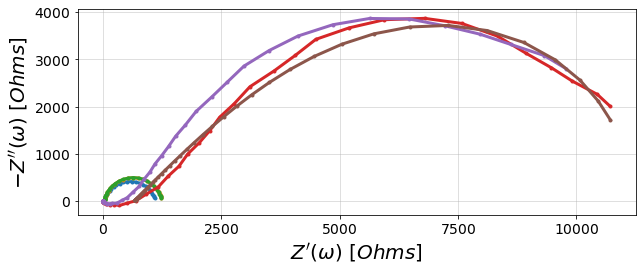

In [527]:
par_out= IC.sub_Zg_parallel(f_adj, Z_adj, .7, result.x, num=11, show_plot=False)

f_p = f_adj[np.argmin(par_out.imag)]
C_guess = 1 / (2*np.pi * f_p * par_out[0, -1].real)
PostZg = CustomCircuit(circuit='R0-p(R1,E1)', initial_guess=[par_out[0,15].real, par_out[0,-1].real, C_guess, .8])
PostZg.fit(f_adj[15:], par_out[0, 15:])
print(PostZg.parameters_)
Z_pZg = PostZg.predict(f_adj[15:]) 

ZZ = IC.par_RCPE_subtract(PostZg.parameters_[1:], f_adj, Z_adj)
ZZ2 = IC.par_RCPE_subtract([1227.361, 8.5e-5, .90185877], f_adj, Z_adj)

dum_circ = CustomCircuit(circuit='R1-G', initial_guess=[None, 12000, .2], constants={'R1': 650})
dum_circ.fit(f_adj, ZZ)

ZZ_p = dum_circ.predict(f_adj)
print(dum_circ.parameters_)

fig, ax = plt.subplots(figsize=(10,10))
plot_nyquist(ax, f_adj, Z_adj)
plot_nyquist(ax, f_adj, Z_pZg)
plot_nyquist(ax, f_adj, par_out[0])
plot_nyquist(ax, f_adj, ZZ)
plot_nyquist(ax, f_adj, ZZ2)
plot_nyquist(ax, f_adj, ZZ_p)

# ax.set_xlim(0,800)
# ax.set_ylim(-200,700)

In [514]:
dum_circ = CustomCircuit(circuit='R1-G', initial_guess=[None, 12000, .2], constants={'R1': 800})
dum_circ.fit(f_adj, ZZ)

ZZ_p = dum_circ.predict(f_adj)



In [438]:
RC0 = PostZg.parameters_[1:]
print(RC0)
d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16


resRCPE = least_squares(IC.Par_RCPE_Res, RC0, method= 'trf', args=(f_adj, Z_adj), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
resRCPE

[1.23544968e+03 1.04482330e-04 8.68185877e-01]


 active_mask: array([0., 0., 0.])
        cost: 0.00016073652157873412
         fun: array([0.01792967])
        grad: array([ 0.00000000e+00, -3.49059286e+01, -2.24120867e-03])
         jac: array([[ 0.00000000e+00, -1.94682501e+03, -1.25000000e-01]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 58
        njev: 23
  optimality: 34.90592864082627
      status: 3
     success: True
           x: array([1.23544968e+03, 4.50822966e-06, 8.68185321e-01])

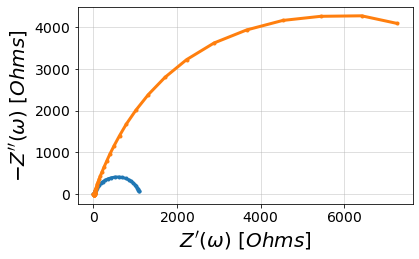

In [423]:
ZZZ = IC.par_RCPE_subtract(resRCPE.x, f_adj, Z_adj)

fig, ax = plt.subplots()
plot_nyquist(ax, f_adj, Z_adj)
plot_nyquist(ax, f_adj, ZZZ)

In [144]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*1%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0 = preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par


24 (686.898087322533-562.8687843225954j) 12.825167569241444 0 0
24 (674.9713187380408-553.6919165768278j) 10.323176303795321 0 0
24 (663.9611183159086-545.2024563688464j) 8.081499163629246 0 0
24 (653.7761633035259-537.3340279601216j) 6.066164418275321 0 0
24 (644.3366909504435-530.0283880749315j) 4.248518621541052 0 0
24 (635.5727239749295-523.2342167977613j) 2.6042632756787043 0 0
24 (627.4226133300834-516.9061180157194j) 1.1126883454375616 0 0
24 (619.8318340094988-511.0037882517951j) -0.2439419269109635 0 0
24 (612.7519840830935-505.49132171376755j) -1.4808844457147075 0 0
24 (606.1399480493834-500.3366262185423j) -2.611319394146733 0 0
24 (599.9571938768203-495.51092989642814j) -3.6466785708575458 0 0


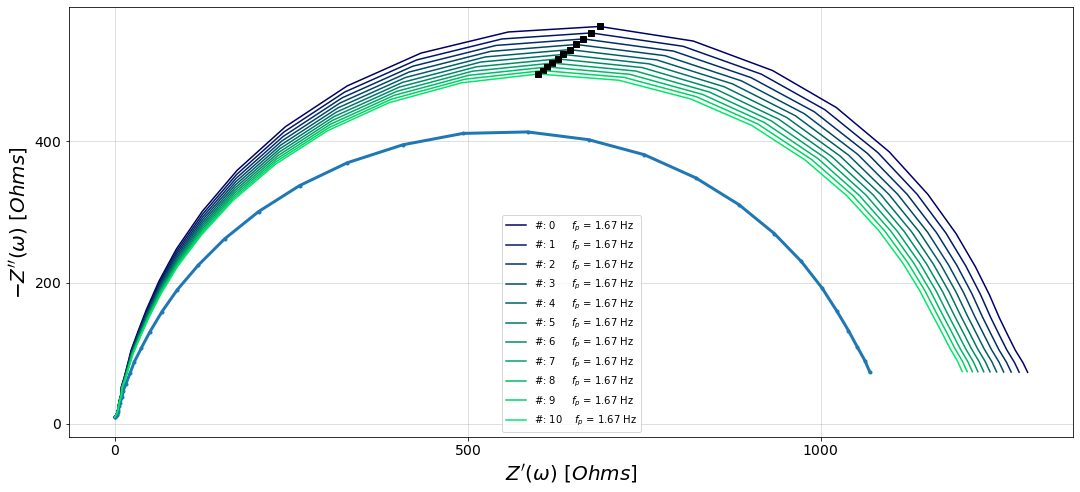

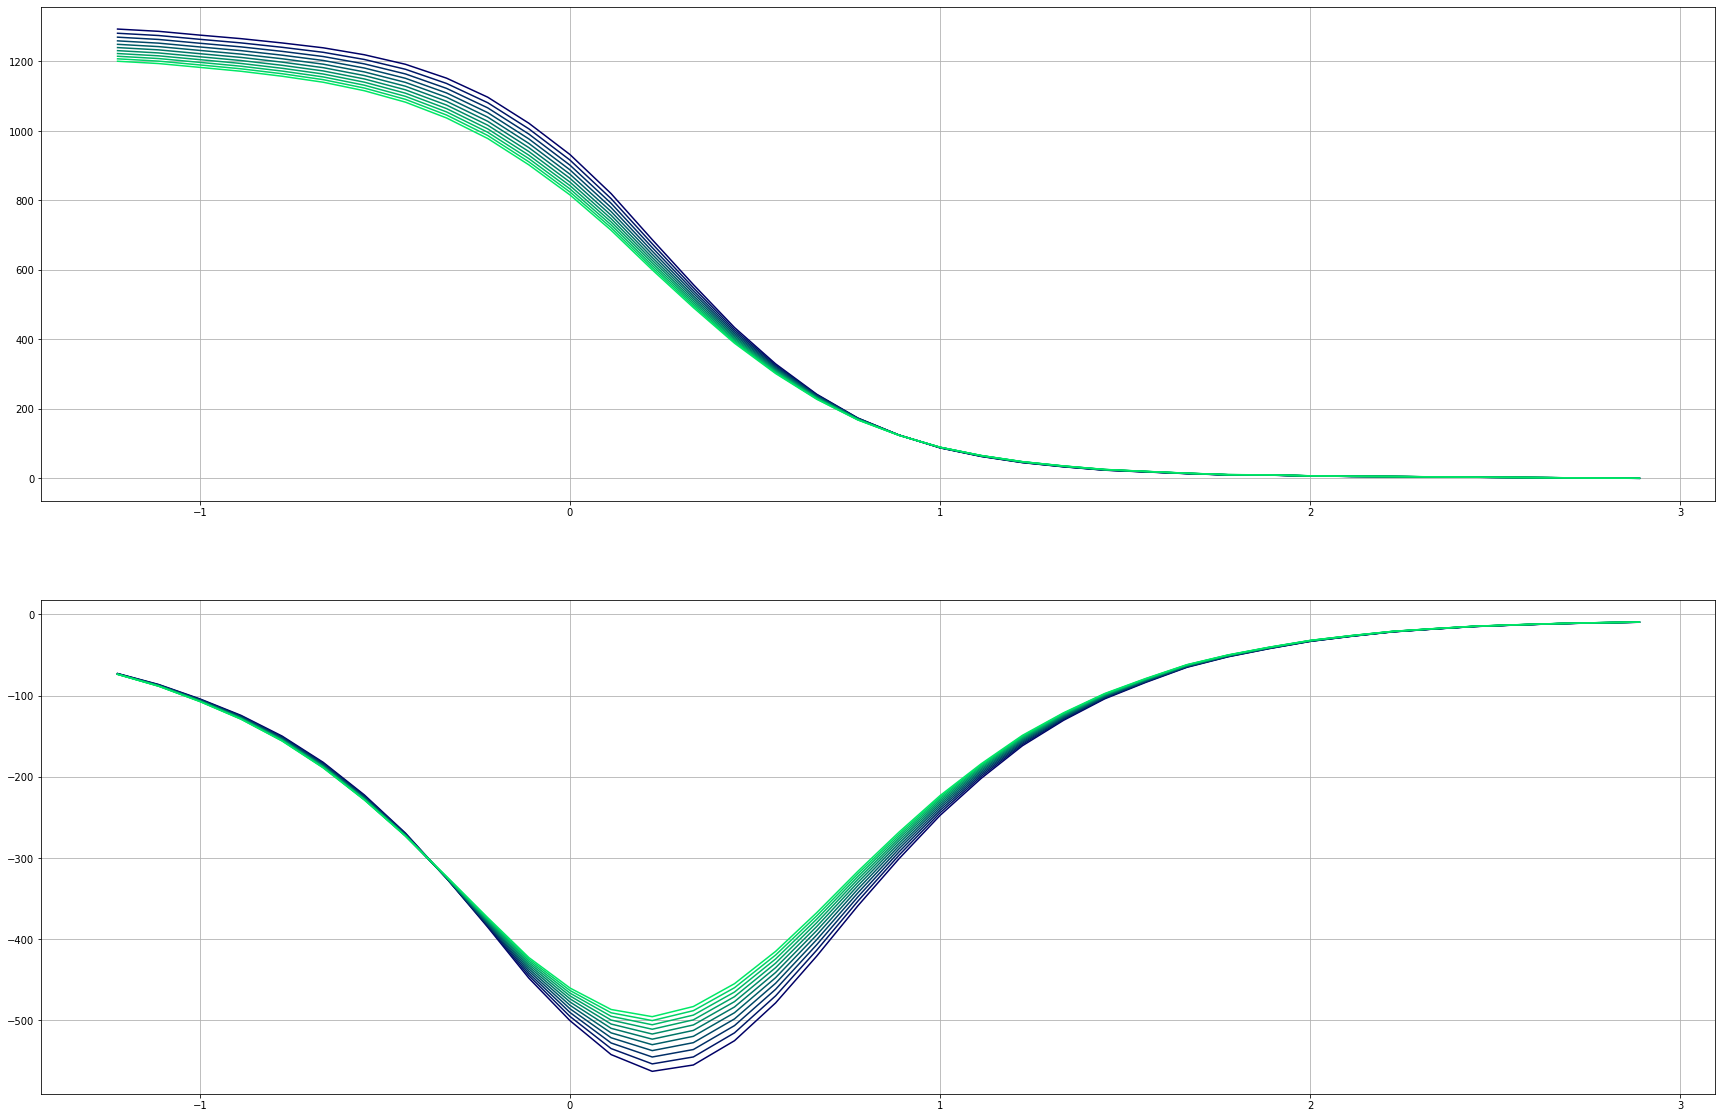

In [331]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .91, [3.8, 4], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 20))
plot_nyquist(ax, freqs, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
        f_p_idx = np.argmin(np.imag(Zs))
        f_p = f_adj[f_p_idx]

        ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
                c=(0, i/len(par_out), .4))
        ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
                c=(0, 0, 0))
        ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))
        ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))

        # ax.set_xlim(-80, 300)
        # ax.set_ylim(-80, 300)
        ax1.grid(True)
        ax2.grid(True)
        ax.legend()
        

C:\Users\shadd\OneDrive\Documents\Python\EIS


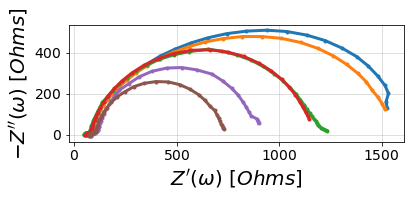

In [15]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

fig, ax = plt.subplots()

for file in all_files:
    f, Z = preprocessing.readVersaStudio(file)
    plot_nyquist(ax, f, Z)

    
# ax.set_xlim(40,150)
# ax.set_ylim(0,100)
plt.show()

In [173]:
all_files

['C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par']

In [143]:
from impedance.validation import linKK

In [ ]:
linKK()